# Logger

In [53]:
import logging
import os
import sys
from datetime import datetime
import sys


# Define log file name and path
log_file = f"LOG {datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.log"

#Custome logger
logger = logging.getLogger("LOG")
logger.setLevel(logging.DEBUG)

#Create Handler
c_handler = logging.StreamHandler()

c_handler.setLevel(logging.DEBUG)

#Setting the Format
c_format = logging.Formatter("%(asctime)s - %(name)s - %(module)s - %(levelname)s : %(message)s", datefmt='%Y-%m-%d %H:%M:%S')

c_handler.setFormatter(c_format)

#Add Handler
logger.addHandler(c_handler)


# Exceptions

In [48]:
import sys

def error_message_detail(error):
    _,_,exc_tb = sys.exc_info()
    file_name = exc_tb.tb_frame.f_code.co_filename

    error_message = "Error occured in python script name [{0}] line number [{1}] error message [{2}]".format(
        file_name, exc_tb.tb_lineno, str(error)
    )
    return error_message

class CustomException(Exception):

    def __init__(self, error_message:str):
        super().__init__(error_message)
        self.error_message = error_message_detail(error_message)

    def __str__(self) -> str:
        return self.error_message

# Utils

In [49]:
import os
import pickle
import yaml
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score



def replace_null_with_mean(df, num_cols):
    """
    This function replaces null values in the specified numerical columns of a DataFrame with their mean.

    Parameters:
    df (pandas.DataFrame): The DataFrame.
    num_cols (list): The list of numerical columns.

    Returns:
    pandas.DataFrame: The DataFrame with null values replaced.
    """
    for col in num_cols:
        if col in df.columns:
            df[col].fillna(df[col].mean(), inplace=True)
    return df

def save_objects(file_path, obj):
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(obj, f)
        logger.info("Object saved successfully")
    except Exception as e:
        logger.info("Error in save_objects: {}".format(e))
        
def outlier_removal(df, num_cols):
    for column in num_cols:
        upper_limit = df[column].mean() + 2 * df[column].std()
        lower_limit = df[column].mean() - 2 * df[column].std()
        df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df

def fill_empty_with_mode(df, cat_cols):
    for i in cat_cols:
        if (df[i] == '').any():
            mode_value = df[i][df[i]!=""].mode().iloc[0]
            df[i] = df[i].replace('',mode_value )
    return df




def random_search_cv(model, X_train, y_train,params):
    random_cv = RandomizedSearchCV(model, param_distributions=params, scoring="r2", cv = 5, verbose=0 )
    random_cv.fit(X_train, y_train)
    return random_cv, random_cv.best_params_, random_cv.best_score_

#Confusion Matrix

def confusion_matrix_classification_report(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    
    #Classification Report
    report = classification_report(y_test, y_pred)
    logger.info(report)
    

class FeatureClassifier:
    def __init__(self,df, target_column):
        self.df = df
        self.target_column = target_column
    
    def get_ordinal_columns_mapping(self,columns):
        """
        This function is used to get the mapping of ordinal columns.
        Each key is named as 'ColumnName_Map' and contains the unique values for that column.
        """
        columns_mapping = {}
        
        for col in columns:
            sorted_groups = self.df.groupby(col)[self.target_column].mean().sort_values().index.tolist()
            key_name = f"{col}"
            columns_mapping[key_name] = sorted_groups
        
        return columns_mapping
        

        
    def ordinal_onehot_numerical_divide(self):
        """
        This function is used to divide the categorical into ordinal and one-hot columns and numerical columns.
        """
        one_hot_cols = []
        ordinal_cols = []
        num_cols = []
        #Overall mean
        mean = self.df[self.target_column].mean()
        thereshold_percentage = 0.1
        threshold_value = mean * thereshold_percentage
        try:
            for column in self.df.columns:
                if column != self.target_column and self.df[column].dtype == 'object':
                    df_column = self.df[[column, self.target_column]].groupby(column).mean().reset_index()
                    standard_dev = df_column[self.target_column].std()
                    if standard_dev > threshold_value:
                        ordinal_cols.append(column)
                    else:
                        one_hot_cols.append(column)
                else:
                    num_cols.append(column)
            
            logger.info("ordinal_onehot_numerical_divide done!!!")

            #Get Mappingsd for ordinal columns:
            ordinal_columns_mapping = self.get_ordinal_columns_mapping(ordinal_cols)
            one_hot_column_mapping = self.get_ordinal_columns_mapping(one_hot_cols)
            return (one_hot_cols, ordinal_cols, num_cols, ordinal_columns_mapping, one_hot_column_mapping)
                 

        except Exception as e:
            logger.info(e)

def save_objects(file_path, obj):
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(obj, f)
        logger.info("Object saved successfully")
    except Exception as e:
        logger.info("Error in save_objects: {}".format(e))
    

def load_obj(file_path):
    try:
        with open(file_path, 'rb') as f:
            obj = pickle.load(f)
        logger.info("Object loaded successfully")
        return obj
    except Exception as e:
        logger.info("Error in load_obj: {}".format(e))
    
from sklearn.metrics import accuracy_score


def random_search_cv_classification(model, X_train, y_train, params):
    random_cv = RandomizedSearchCV(model, param_distributions=params, scoring="accuracy", cv = 5, verbose=0 )
    random_cv.fit(X_train, y_train)
    return random_cv, random_cv.best_params_, random_cv.best_score_


def random_search_cv_regression(model, X_train, y_train, params):
    random_cv = RandomizedSearchCV(model, param_distributions=params, scoring="r2", cv = 5, verbose=0)
    random_cv.fit(X_train, y_train)
    return random_cv, random_cv.best_params_, random_cv.best_score_


def evaluate_model_classification(X_train, y_train, X_test, y_test, models):
    report = {}
    config = {
                "SVC": {
                    "C": [0.1, 1, 10, 100],
                    "kernel": ["linear", "poly", "rbf", "sigmoid"],
                    "degree": [2, 3, 4, 5],
                    "gamma": ["scale", "auto"]
                },
                "DecisionTree": {
                    "max_depth": [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,28,29,20],
                    "min_samples_split": [2,3,4,5,6,7,8,9,10],
                    "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10]
                },
                "RandomForest": {
                    "n_estimators": [50, 100, 150, 200],
                    "max_depth": [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,28,29,20],
                    "min_samples_split": [2,3,4,5,6,7,8,9,10],
                    "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10]
                },
                "GradientBoostingClassification": {
                    "n_estimators": [50, 100, 150, 200],
                    "learning_rate": [0.01, 0.1, 0.2],
                    "max_depth": [2,3,4,5,6,7,8,9,10],
                    "min_samples_split": [2,3,4,5,6,7,8,9,10],
                    "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10]
                },
                "BaggingClassification": {
                    "n_estimators": [10, 50, 100],
                    "max_samples": [0.5, 0.7, 1.0],
                    "max_features": [0.5, 0.7, 1.0],
                    "bootstrap": [True, False],
                    "bootstrap_features": [True, False]
                }
            }

    try:
        
        for i in range(len(models)):
            model = list(models.values())[i]
            model_flag = list(models.keys())[i]
            # model.fit(X_train, y_train)
            
            params = config[model_flag]
            model, model.best_params_, model.best_score_ = random_search_cv_classification(model, X_train, y_train, params)
            
            y_pred = model.predict(X_test)

            test_model_score = accuracy_score(y_test, y_pred)
            logger.info('\n====================================================================================\n')
            logger.info(f"The confusion matrix and classification report for the model: {model_flag} is:")
            confusion_matrix_classification_report(y_test, y_pred)
            logger.info('\n====================================================================================\n')


            logger.info('\n====================================================================================\n')
            logger.info(f"The best parameters for the model{model_flag} are {model.best_params_}")
            logger.info('\n====================================================================================\n')


            report[list(models.keys())[i]] =  {"score": test_model_score, "best_params": model.best_params_}
            logger.info(f"Model: {list(models.keys())[i]}, Accuracy score: {test_model_score}")
        logger.info("Model evaluation complete")
        return report

    except Exception as e:
        logger.info("Error in evaluate_model: {}".format(e))
        



def evaluate_model_regression(X_train, y_train, X_test, y_test, models):
    report = {}

    try:
        with open(regression_param_path, 'r') as file:  # Ensure correct path to your regression parameters file
            config = yaml.safe_load(file)

        for i in range(len(models)):
            model = list(models.values())[i]
            model_flag = list(models.keys())[i]

            params = config[model_flag]
            model, model.best_params_, model.best_score_ = random_search_cv_regression(model, X_train, y_train, params)

            y_pred = model.predict(X_test)

            test_model_score = r2_score(y_test, y_pred)  # R-squared used as evaluation metric
            logger.info('\n====================================================================================\n')
            logger.info(f"The R-squared and RMSE for the model: {model_flag} are:")
            logger.info(f"R-squared: {test_model_score}")  # Reporting RMSE along with R-squared
            logger.info('\n====================================================================================\n')

            logger.info('\n====================================================================================\n')
            logger.info(f"The best parameters for the model {model_flag} are {model.best_params_}")
            logger.info('\n====================================================================================\n')

            report[list(models.keys())[i]] = {"score": test_model_score, "best_params": model.best_params_}
            logger.info(f"Model: {list(models.keys())[i]}, R-squared: {test_model_score}")
        logger.info("Model evaluation complete")
        return report

    except Exception as e:
        logger.info("Error in evaluate_model: {}".format(e))
        raise e

In [70]:
import os # We use os to create path...
import sys
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer ## HAndling Missing Values
from sklearn.preprocessing import StandardScaler # HAndling Feature Scaling
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder # Ordinal Encoding for categorical variables
## pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer #Group everything together
from dataclasses import dataclass
import json


class DataTransformation:
    
    def __init__(self):
        pass
    

    def get_data_transformation_object(self, categories, one_hot_cols, ordinal_cols, num_cols, target):
        
        try:
            # Independent numerical columns
            num_cols_list = [num for num in num_cols if num != target]  ##It can be automated via taking from UI

            # Define pipelines for categorical and numeric data
            categorical_onehot_pipeline = Pipeline([
                
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder()),
                ('scaler', StandardScaler(with_mean=False))
            ])

            categorical_ordinal_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OrdinalEncoder(categories=categories)),
                ('scaler', StandardScaler(with_mean=False))
            ])

            numerical_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ])

            # Combine pipelines in a ColumnTransformer
            preprocessor = ColumnTransformer(transformers=[
                ('cat_one_hot', categorical_onehot_pipeline, one_hot_cols),
                ('cat_ordinal', categorical_ordinal_pipeline, ordinal_cols),
                ('num', numerical_pipeline, num_cols_list)
            ])

            logger.info("Pipeline methods creation ends!!!")
            return preprocessor
        
        except Exception as e:
            logger.error("Error in get_data_transformation_object")
            raise e
            
    def inititate_data_transformation(self, df_train, df_test, target, features_to_exclude, user_transformation_name=None):
        try:
            
            logger.info("Initiating data transformation process...")
                
            
            df_train.drop(labels=features_to_exclude, axis=1, inplace=True)
            df_test.drop(labels=features_to_exclude, axis=1, inplace=True)
            logger.info("Features excluded successfully")
            
            # Number columns:
            num_cols = [col for col in df_train.columns if df_train[col].dtype!= 'object' and col != target]
            #Categorical Column:
            cat_cols = [col for col in df_train.columns if df_train[col].dtype == 'object' and col != target]

            logger.info("Number columns identified successfully")
        
            
            #Replacing NA with mean
            df_train = replace_null_with_mean(df_train, num_cols)
            df_test = replace_null_with_mean(df_test, num_cols)
            logger.info("Replaced Null with mean for input numerical variables")
            logger.info(df_train.shape)
            logger.info(df_test.shape)
            
            ##Replacing NA with mean for Target Variable:
            df_train = replace_null_with_mean(df_train, [target])
            df_test = replace_null_with_mean(df_test, [target])            
            logger.info("Replaced Null with mean for Target Variable")
            
            #Fill empty feature with mode
            df_train = fill_empty_with_mode(df_train,cat_cols)
            logger.info("Empty values filled with mode successfully")

            df_test = fill_empty_with_mode(df_test,cat_cols)
            logger.info("Empty values filled with mode successfully")
            
            
            # Calling Feature Classifier for training data:
            feature_classifier_obj = FeatureClassifier(df_train,target)
            one_hot_cols, ordinal_cols, num_cols, ordinal_columns_mapping, one_hot_column_mapping = feature_classifier_obj.ordinal_onehot_numerical_divide()
            logger.info("Categorical columns (one hot, ordinal mapping)  and numerical columns divided successfully")


            
            logger.info(one_hot_cols, ordinal_cols, num_cols, ordinal_columns_mapping, one_hot_column_mapping)
            # Listing all the categories:
            categories = []
            for key, value in ordinal_columns_mapping.items():
                categories.append(value)
            logger.info("Categories created successfully!!!")
            

            preprocessor_obj = self.get_data_transformation_object(categories, one_hot_cols, ordinal_cols, num_cols, target)
            
            # Segregation of input and target feature:

            
            X_train = df_train.drop(labels=target, axis=1)
            y_train = df_train[target]

            X_test = df_test.drop(labels=target, axis=1)
            y_test = df_test[target]

            logger.info("Input and target feature segregated successfully!!!")
        

            # #Transformation using preprocessing object:
            X_train_arr = preprocessor_obj.fit_transform(X_train)
            logger.info(X_train_arr)
            # Convert the array back into a dataframe
            X_train_df = pd.DataFrame(X_train_arr, columns=preprocessor_obj.get_feature_names_out())

            logger.info(X_train_df)

            X_test_arr = preprocessor_obj.transform(X_test)
            # Convert the array back into a dataframe
            X_test_df = pd.DataFrame(X_test_arr, columns=preprocessor_obj.get_feature_names_out())
            logger.info("Preprocessing done successfully!!!")

            train_arr = np.c_[X_train_arr, np.array(y_train)]
            test_arr = np.c_[X_test_arr, np.array(y_test)]

            logger.info("Data transformation done successfully!!!")

 
            logger.info("ordinal_columns_mapping.json created successfully!!!")
            
  
            return train_arr, test_arr, X_train_df, X_test_df, preprocessor_obj
        except Exception as e:
            logger.error("Error occured while initiating the data transformation process: {}".format(e))
            raise e



# Importing the Dataset

In [71]:
# from project_lib import Project
# project = Project()
# mortgage_data = project.get_file('Detroit_mortgage_data.csv')

In [80]:
import pandas as pd

# Convert BytesIO object to pandas DataFrame
df = pd.read_csv("../data/Mortgage_Test_Data_Raw.csv")

df

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,derived_race,derived_sex,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,loan_to_value_ratio,interest_rate,rate_spread,hoepa_status,total_loan_costs,total_points_and_fees,origination_charges,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,interest_only_payment,balloon_payment,other_nonamortizing_features,property_value,construction_method,occupancy_type,manufactured_home_secured_property_type,manufactured_home_land_property_interest,total_units,multifamily_affordable_units,income,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,applicant_ethnicity-1,applicant_ethnicity-2,applicant_ethnicity-3,applicant_ethnicity-4,applicant_ethnicity-5,co-applicant_ethnicity-1,co-applicant_ethnicity-2,co-applicant_ethnicity-3,co-applicant_ethnicity-4,co-applicant_ethnicity-5,applicant_ethnicity_observed,co-applicant_ethnicity_observed,applicant_race-1,applicant_race-2,applicant_race-3,applicant_race-4,applicant_race-5,co-applicant_race-1,co-applicant_race-2,co-applicant_race-3,co-applicant_race-4,co-applicant_race-5,applicant_race_observed,co-applicant_race_observed,applicant_sex,co-applicant_sex,applicant_sex_observed,co-applicant_sex_observed,applicant_age,co-applicant_age,applicant_age_above_62,co-applicant_age_above_62,submission_of_application,initially_payable_to_institution,aus-1,aus-2,aus-3,aus-4,aus-5,denial_reason-1,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,5493000YNV8IX4VD3X12,19804,MI,26163,2.616357e+10,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Not Hispanic or Latino,Race Not Available,Female,3,0,2,1,1,1,2,2,2,35000,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,300.0,NaN,NaN,2,2,2,2,75000.0,2,1,2,3,1,NaN,48.0,>60%,8,10,2,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,2,4,6.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2,4,2,5,2,4,45-54,9999,No,NaN,1,1,6,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,4328,16.20,72800,120,1245,1484,63
1,2022,5493000YNV8IX4VD3X12,19804,MI,26163,2.616356e+10,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Not Hispanic or Latino,White,Male,3,0,2,1,1,1,2,2,2,55000,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,300.0,NaN,NaN,2,2,2,2,55000.0,2,1,2,3,1,NaN,73.0,<20%,8,8,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,2,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,2,1,3,2,2,65-74,55-64,Yes,Yes,1,1,6,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,5439,11.09,72800,192,1947,2033,43
2,2022,5493000YNV8IX4VD3X12,19804,MI,26163,2.616360e+10,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Ethnicity Not Available,Race Not Available,Sex Not Available,6,0,2,1,5,1,2,2,2,45000,NaN,9.990,NaN,2,NaN,NaN,NaN,NaN,NaN,360.0,NaN,NaN,2,2,2,2,65000.0,2,1,2,3,1,NaN,NaN,NaN,9,9,4,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,3,3,7.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,3,3,4,4,3,3,8888,8888,NaN,NaN,3,3,6,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,4997,14.93,72800,139,1498,1801,48
3,2022,5493000YNV8IX4VD3X12,19804,MI,26163,2.616357e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,Asian,Male,4,0,2,1,1,1,2,2,2,225000,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,360.0,NaN,NaN,2,2,2,2,NaN,1,1,3,5,1,NaN,119.0,NaN,9,9,2,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,2,4,2.0,21.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2,4,1,5,2,4,25-34,9999,No,NaN,1,1,1,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,3529,32.05,72800,128,1113,1237,41
4,2022,54930077D8KXQADF5Q23,19804,MI,26163,2.616357e+10,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Joint,1,2,2,2,1,1,2,2,2,185000,79.614,5.625,1.418,2,10645.81,NaN,5

In [81]:
df = df[['debt_to_income_ratio','applicant_credit_score_type', 'co-applicant_credit_score_type','derived_sex','applicant_ethnicity-1', 'derived_race','co-applicant_ethnicity-1','applicant_sex_observed', 'action_taken', 'purchaser_type', 'preapproval','tract_minority_population_percent','loan_type', 'loan_purpose','tract_population', 'income','ffiec_msa_md_median_family_income','tract_median_age_of_housing_units','applicant_age', 'applicant_age_above_62','co-applicant_age_above_62','loan_amount']]
df['action_taken_final'] = np.where(df['action_taken'] == 3, 'Denied', 'Approved')
df['action_taken_final'] = df['action_taken_final'].map({'Approved': 1, 'Denied': 0}).astype(bool)
df['action_taken_final'].unique()

C:\Users\abhishdutta\AppData\Local\Temp\ipykernel_26796\3947422335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['action_taken_final'] = np.where(df['action_taken'] == 3, 'Denied', 'Approved')
C:\Users\abhishdutta\AppData\Local\Temp\ipykernel_26796\3947422335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['action_taken_final'] = df['action_taken_final'].map({'Approved': 1, 'Denied': 0}).astype(bool)


array([False,  True])

In [74]:
#Give the target variable and the input features to be excluded

target = "action_taken_final"  #List the target variabler
features_to_exclude = [] #List the input features to exclude


# Split the dataframe into df_train and df_test

In [75]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)



In [76]:
data_transformation_obj = DataTransformation()
train_arr, test_arr, train_df, test_df, preprocessor_obj = data_transformation_obj.inititate_data_transformation(df_train, df_test, target, features_to_exclude)

2024-05-17 12:50:08 - LOG - 499418439 - INFO : Initiating data transformation process...
2024-05-17 12:50:08 - LOG - 499418439 - INFO : Initiating data transformation process...
2024-05-17 12:50:08 - LOG - 499418439 - INFO : Initiating data transformation process...
2024-05-17 12:50:08 - LOG - 499418439 - INFO : Features excluded successfully
2024-05-17 12:50:08 - LOG - 499418439 - INFO : Features excluded successfully
2024-05-17 12:50:08 - LOG - 499418439 - INFO : Features excluded successfully
2024-05-17 12:50:08 - LOG - 499418439 - INFO : Number columns identified successfully
2024-05-17 12:50:08 - LOG - 499418439 - INFO : Number columns identified successfully
2024-05-17 12:50:08 - LOG - 499418439 - INFO : Number columns identified successfully
C:\Users\abhishdutta\AppData\Local\Temp\ipykernel_26796\2773074984.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.

In [10]:
train_df.columns

Index(['cat_one_hot__co-applicant_age_above_62_No',
       'cat_one_hot__co-applicant_age_above_62_Yes',
       'cat_ordinal__debt_to_income_ratio', 'cat_ordinal__derived_sex',
       'cat_ordinal__derived_race', 'cat_ordinal__applicant_age',
       'cat_ordinal__applicant_age_above_62',
       'num__applicant_credit_score_type',
       'num__co-applicant_credit_score_type', 'num__applicant_ethnicity-1',
       'num__co-applicant_ethnicity-1', 'num__applicant_sex_observed',
       'num__action_taken', 'num__purchaser_type', 'num__preapproval',
       'num__tract_minority_population_percent', 'num__loan_type',
       'num__loan_purpose', 'num__tract_population', 'num__income',
       'num__ffiec_msa_md_median_family_income',
       'num__tract_median_age_of_housing_units', 'num__loan_amount'],
      dtype='object')

In [11]:
import os
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
import json
from dataclasses import dataclass
import yaml


class InitiateModelTraining:

    def initiate_model_training(self, train_array, test_array, user_model_name = None):
        """
        This function is used to initiate the model training process.
        """
        logger.info("Initiating model training process...")
        try:
            X_train, y_train, X_test, y_test = (
                train_array[:,:-1],
                train_array[:,-1],
                test_array[:,:-1],
                test_array[:,-1]
                )

            models = {
                "SVC": SVC(),
                "DecisionTree": DecisionTreeClassifier(random_state=42),
                "RandomForest": RandomForestClassifier(random_state=42),
                "GradientBoostingClassification": GradientBoostingClassifier(random_state=42),
                "BaggingClassification" : BaggingClassifier(random_state=42)
            }
            
            model_report: dict = evaluate_model_classification(X_train, y_train, X_test, y_test, models=models)

            logger.info('\n====================================================================================\n')
            logger.info(f'Model Report : {model_report}')
            logger.info('\n====================================================================================\n')

            # Get the model names and their scores
            model_scores = {model_name: model_info['score'] for model_name, model_info in model_report.items()}

            # Find the model with the best score
            best_model_name = max(model_scores, key=model_scores.get)
            best_model_score = model_scores[best_model_name]

            # Get the best parameters for the best model
            best_model_params = model_report[best_model_name]['best_params']
            best_model = models[best_model_name]
            
            # Create a new instance of the model using the best parameters
            best_model = models[best_model_name].set_params(**best_model_params)

            # Fit the model with the best parameters
            best_model.fit(X_train, y_train)
            
            logger.info(f"Model Name is:{best_model_name} and the best parameters are:{best_model_params}, with score {best_model_score}")

        except Exception as e:
            logger.error("Error initiating model training process", e)
            raise e


2024-05-15 18:22:05 - LOG - 1798041921 - INFO : Initiating model training process...
2024-05-15 18:22:12 - LOG - 2773074984 - INFO : 

2024-05-15 18:22:12 - LOG - 2773074984 - INFO : The confusion matrix and classification report for the model: SVC is:
2024-05-15 18:22:12 - LOG - 2773074984 - INFO :               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       250
         1.0       0.99      0.98      0.98       362

    accuracy                           0.98       612
   macro avg       0.98      0.98      0.98       612
weighted avg       0.98      0.98      0.98       612

2024-05-15 18:22:12 - LOG - 2773074984 - INFO : 

2024-05-15 18:22:12 - LOG - 2773074984 - INFO : 

2024-05-15 18:22:12 - LOG - 2773074984 - INFO : The best parameters for the modelSVC are {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 10}
2024-05-15 18:22:12 - LOG - 2773074984 - INFO : 

2024-05-15 18:22:12 - LOG - 2773074984 - INFO : Model: SVC, Accuracy score:

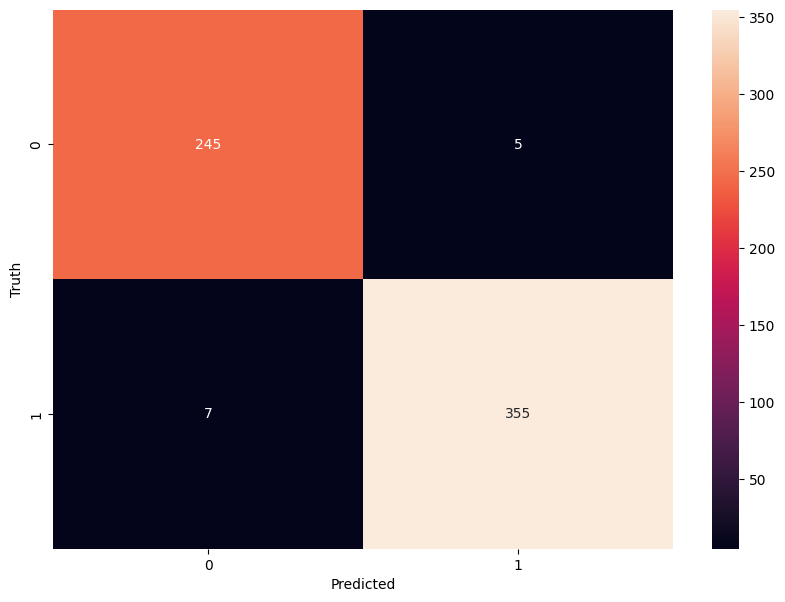

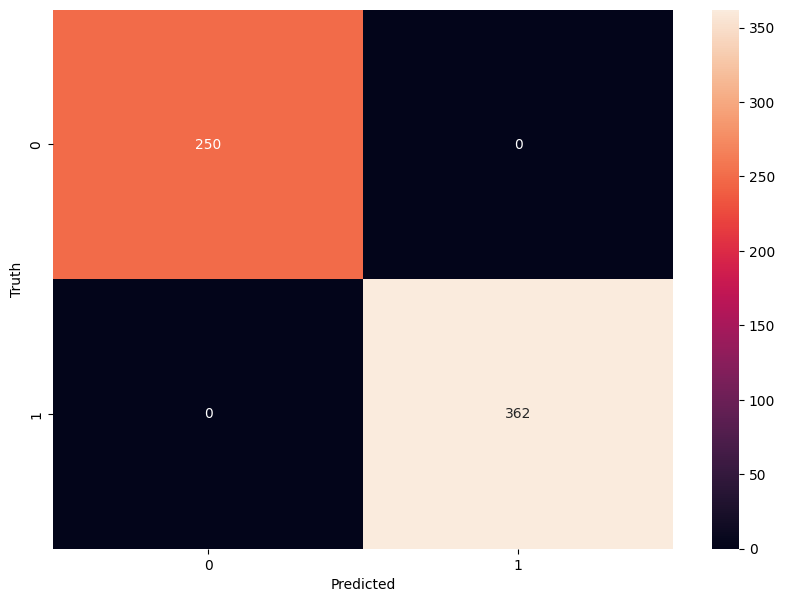

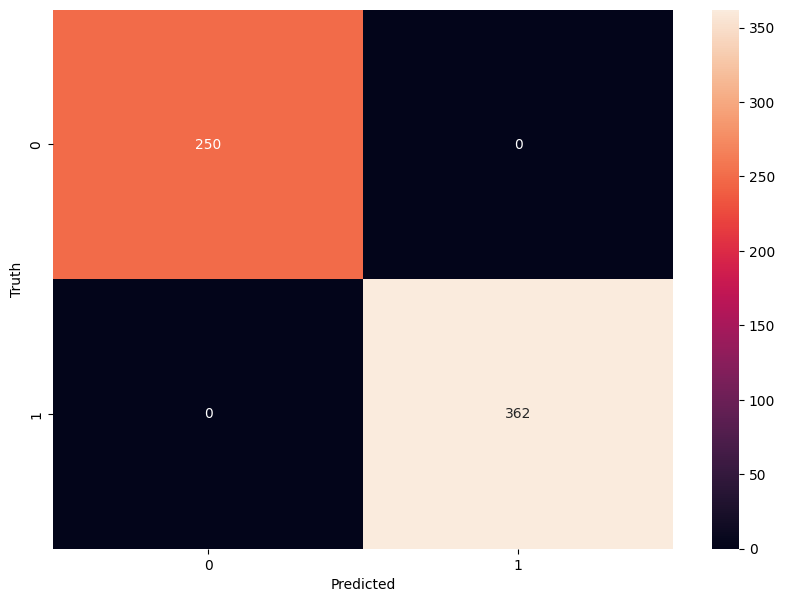

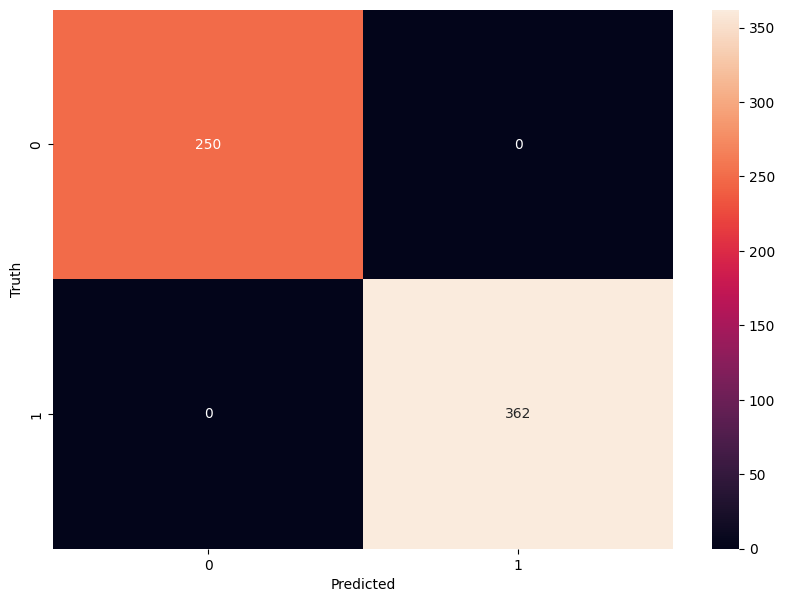

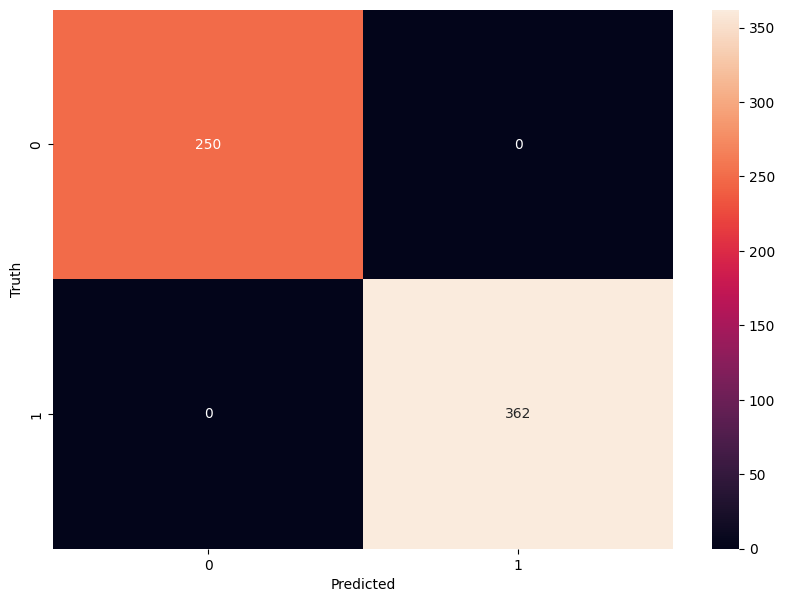

In [12]:
model_trainer_obj = InitiateModelTraining()
model_trainer_obj.initiate_model_training(train_arr, test_arr, "hmda")

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameters
best_param = {'n_estimators': 50, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_depth': 11}

# Initialize the RandomForestClassifier with the best parameters
clf_model = RandomForestClassifier(n_estimators=best_param['n_estimators'],
                             min_samples_split=best_param['min_samples_split'],
                             min_samples_leaf=best_param['min_samples_leaf'],
                             max_depth=best_param['max_depth'])


In [61]:
X_train, y_train, X_test, y_test = (
                train_arr[:,:-1],
                train_arr[:,-1],
                test_arr[:,:-1],
                test_arr[:,-1]
                )

In [28]:
model = clf_model.fit(train_df, y_train)

In [31]:
test_df

,cat_one_hot__co-applicant_age_above_62_No,cat_one_hot__co-applicant_age_above_62_Yes,cat_ordinal__debt_to_income_ratio,cat_ordinal__derived_sex,cat_ordinal__derived_race,cat_ordinal__applicant_age,cat_ordinal__applicant_age_above_62,num__applicant_credit_score_type,num__co-applicant_credit_score_type,num__applicant_ethnicity-1,...,num__preapproval,num__tract_minority_population_percent,num__loan_type,num__loan_purpose,num__tract_population,num__income,num__ffiec_msa_md_median_family_income,num__tract_median_age_of_housing_units,num__loan_amount,action_taken_final
0,4.439947,0.0,0.887783,0.000000,2.858058,0.483394,0.000000,0.779737,-0.214073,-0.318258,...,0.099586,-0.833436,-0.236682,1.821254,2.541218,-0.147074,0.0,-1.139399,0.535503,1.0
1,4.439947,0.0,0.887783,0.000000,2.858058,2.416970,2.556168,-2.052405,0.499698,-0.318258,...,0.099586,-0.398691,-0.236682,1.821254,-1.515922,-0.449803,0.0,0.274845,0.019593,1.0
2,4.439947,0.0,0.887783,0.000000,4.001282,0.483394,0.000000,0.779737,-0.214073,0.304688,...,0.099586,1.375913,-0.236682,-0.610711,0.205574,-0.015115,0.0,1.415363,-0.261812,1.0
3,4.439947,0.0,0.000000,0.967178,2.858058,2.416970,2.556168,0.425719,0.499698,-0.318258,...,0.099586,-0.383518,-0.236682,-0.367515,-0.689328,-0.426516,0.0,-0.546329,-0.308713,0.0
4,4.439947,0.0,0.887783,2.901535,4.001282,3.383758,0.000000,0.779737,-0.214073,0.927634,...,0.099586,-1.100945,3.401371,-0.286449,2.257958,-0.067082,0.0,1.369743,-0.355614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,4.439947,0.0,0.665838,0.000000,1.143223,0.966788,0.000000,-0.990352,-0.214073,-0.318258,...,0.099586,-0.421780,-0.236682,-0.610711,0.137266,-0.247984,0.0,-0.272605,-0.214911,1.0
608,4.439947,0.0,0.887783,0.967178,2.858058,2.416970,2.556168,-1.698387,0.499698,-0.318258,...,0.099586,-0.885882,-0.236682,1.821254,-0.662381,-0.201410,0.0,0.320465,0.019593,1.0
609,4.439947,0.0,0.443892,0.000000,1.143223,1.450182,0.000000,0.425719,0.499698,-0.318258,...,0.099586,1.812307,-0.236682,-0.529646,-0.297025,-0.317844,0.0,1.187260,-0.402515,0.0
610,4.439947,0.0,0.887783,0.967178,2.858058,2.416970,2.556168,0.425719,0.499698,-0.318258,...,0.099586,0.758100,-0.236682,1.821254,-0.273838,0.023696,0.0,0.685431,-0.074209,0.0


In [30]:
y_pred = model.predict(y_test)

c:\Users\abhishdutta\Desktop\PRD Projects\IBM WatsonX\Generalized Model Development\generalizedmodel\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
test_model_score = accuracy_score(y_test, y_pred)
test_model_score

0.9983660130718954

2024-05-15 11:44:47 - LOG - 2773074984 - INFO :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       250
         1.0       1.00      1.00      1.00       362

    accuracy                           1.00       612
   macro avg       1.00      1.00      1.00       612
weighted avg       1.00      1.00      1.00       612



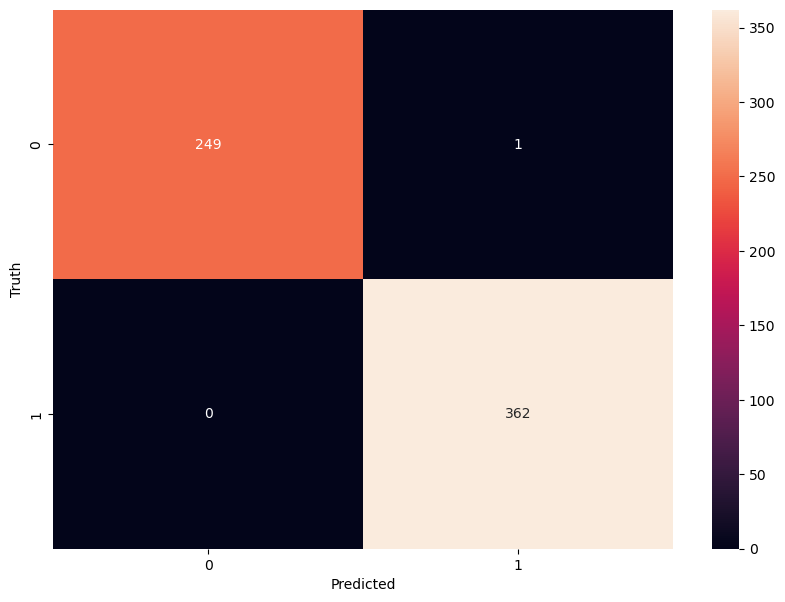

In [27]:
confusion_matrix_classification_report(y_test, y_pred)

In [28]:
import sklearn
print(sklearn.__version__)

1.1.1


In [30]:
import os
import sklearn
from ibm_watson_machine_learning import APIClient

sklearn.__version__

# API_KEY = 'QVTtxoDDPbYgnPGJdOHYKLmiS-Sgsek1l8sB6rVeFFlY'
# # PROJECT_ID = 'dd59ded6-fd9f-4767-b33d-a3b3a84c0deb'
# LOCATION = 'https://cpd-cpd.watsonxgov-fff3dc4eb79e8bb9c13aa1f85391fe02-0000.us-south.containers.appdomain.cloud'

# wml_credentials = {
# #     "apikey": API_KEY,
#     "url": LOCATION,
#     "instance_id" : "openshift",
#     "username": "admin",
#     "password": "IVDPr-CRuKI-buxTz-QQoJf",
#     "version": "4.7"
# }

WOS_CREDENTIALS = {
      "url": 'https://cpd-cpd.watsonxgov-fff3dc4eb79e8bb9c13aa1f85391fe02-0000.us-south.containers.appdomain.cloud',
      "username": "admin",
      "password": "IVDPr-CRuKI-buxTz-QQoJf"
  }
WOS_GUID="00000000-0000-0000-0000-000000000000"
WML_CREDENTIALS = WOS_CREDENTIALS.copy()
WML_CREDENTIALS['instance_id']='openshift'
WML_CREDENTIALS['version']='4.7' #If your env is CP4D 4.x.x then specify "4.x.x" instead of "4.7"
WML_CREDENTIALS

from ibm_watson_machine_learning import APIClient
wml_client = APIClient(WML_CREDENTIALS)
print(wml_client.service_instance.get_url())
# Remove existing model and deployment PR... by Tiwari, Diwas

# Remove existing model and deployment
PRE_PROD_SPACE_NAME = 'Mortgage Baseline RF'
PRE_PROD_CHALLENGER_MODEL_NAME="mortgage_baseline_rf_sklearn"
PRE_PROD_CHALLENGER_DEPLOYMENT_NAME="Mortgage Baseline RF"
MODEL_NAME=PRE_PROD_CHALLENGER_MODEL_NAME
DEPLOYMENT_NAME=PRE_PROD_CHALLENGER_DEPLOYMENT_NAME

wml_client.set.default_project('d84749ac-0093-430a-b115-4b65734909d8')
wml_client.repository.list_models()

# Store Model
software_spec_uid = wml_client.software_specifications.get_id_by_name("runtime-23.1-py3.10")
model_props_gbt = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.DESCRIPTION: MODEL_NAME,
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_1.1"
}
published_model_details = wml_client.repository.store_model(model=model, meta_props=model_props_gbt, training_data=train_df,training_target=y_train)
print(published_model_details)
##############################################################################################
# List models in the repository
wml_client.repository.list_models()
# Get the model UID
challenger_model_uid = wml_client.repository.get_model_id(published_model_details)
print('challenger_model_uid ', challenger_model_uid)

https://cpd-cpd.watsonxgov-fff3dc4eb79e8bb9c13aa1f85391fe02-0000.us-south.containers.appdomain.cloud
--  ----  -------  ----  ----------  ----------------
ID  NAME  CREATED  TYPE  SPEC_STATE  SPEC_REPLACEMENT
--  ----  -------  ----  ----------  ----------------
{'entity': {'hybrid_pipeline_software_specs': [], 'label_column': 'l1', 'schemas': {'input': [{'fields': [{'name': 'cat_one_hot__co-applicant_age_above_62_No', 'type': 'float64'}, {'name': 'cat_one_hot__co-applicant_age_above_62_Yes', 'type': 'float64'}, {'name': 'cat_ordinal__debt_to_income_ratio', 'type': 'float64'}, {'name': 'cat_ordinal__derived_sex', 'type': 'float64'}, {'name': 'cat_ordinal__derived_race', 'type': 'float64'}, {'name': 'cat_ordinal__applicant_age', 'type': 'float64'}, {'name': 'cat_ordinal__applicant_age_above_62', 'type': 'float64'}, {'name': 'num__applicant_credit_score_type', 'type': 'float64'}, {'name': 'num__co-applicant_credit_score_type', 'type': 'float64'}, {'name': 'num__applicant_ethnicity-1', 't

In [32]:
train_df.columns

Index(['cat_one_hot__co-applicant_age_above_62_No',
       'cat_one_hot__co-applicant_age_above_62_Yes',
       'cat_ordinal__debt_to_income_ratio', 'cat_ordinal__derived_sex',
       'cat_ordinal__derived_race', 'cat_ordinal__applicant_age',
       'cat_ordinal__applicant_age_above_62',
       'num__applicant_credit_score_type',
       'num__co-applicant_credit_score_type', 'num__applicant_ethnicity-1',
       'num__co-applicant_ethnicity-1', 'num__applicant_sex_observed',
       'num__action_taken', 'num__purchaser_type', 'num__preapproval',
       'num__tract_minority_population_percent', 'num__loan_type',
       'num__loan_purpose', 'num__tract_population', 'num__income',
       'num__ffiec_msa_md_median_family_income',
       'num__tract_median_age_of_housing_units', 'num__loan_amount'],
      dtype='object')

In [33]:
train_df

,cat_one_hot__co-applicant_age_above_62_No,cat_one_hot__co-applicant_age_above_62_Yes,cat_ordinal__debt_to_income_ratio,cat_ordinal__derived_sex,cat_ordinal__derived_race,cat_ordinal__applicant_age,cat_ordinal__applicant_age_above_62,num__applicant_credit_score_type,num__co-applicant_credit_score_type,num__applicant_ethnicity-1,...,num__purchaser_type,num__preapproval,num__tract_minority_population_percent,num__loan_type,num__loan_purpose,num__tract_population,num__income,num__ffiec_msa_md_median_family_income,num__tract_median_age_of_housing_units,num__loan_amount
0,4.439947,0.000000,0.221946,0.967178,2.858058,1.933576,2.556168,-0.990352,0.499698,-0.318258,...,-0.325753,0.099586,0.143256,-0.236682,-0.610711,-1.093538,-0.457565,0.0,-0.363846,-0.308713
1,4.439947,0.000000,0.887783,0.000000,1.143223,0.483394,0.000000,0.779737,-0.214073,-0.318258,...,-0.325753,0.099586,1.823522,3.401371,1.821254,-0.203023,0.000000,0.0,0.913535,-0.402515
2,4.439947,0.000000,0.887783,0.000000,2.858058,0.966788,0.000000,0.425719,0.499698,-0.318258,...,-0.325753,0.099586,-0.949543,-0.236682,-0.529646,-1.341704,-0.015115,0.0,-2.188676,-0.074209
3,4.439947,0.000000,0.000000,0.967178,2.858058,2.416970,0.000000,0.425719,0.499698,-0.318258,...,-0.325753,0.099586,0.000100,-0.236682,-0.529646,0.552129,-0.418754,0.0,0.320465,-0.449416
4,4.439947,0.000000,0.887783,2.901535,4.001282,3.383758,0.000000,0.779737,-0.214073,0.927634,...,-0.325753,0.099586,-0.417822,-0.236682,-0.610711,1.202625,0.000000,0.0,-0.455088,-0.402515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2439,4.439947,0.000000,0.443892,0.967178,1.143223,2.416970,0.000000,-2.052405,0.499698,-0.318258,...,2.331001,0.099586,1.830119,-0.236682,1.902320,-1.731500,-0.473090,0.0,1.141639,-0.355614
2440,4.439947,0.000000,0.443892,0.000000,1.143223,0.483394,0.000000,0.425719,0.499698,7.157097,...,-0.325753,0.099586,1.858486,-0.236682,-0.529646,-1.639378,0.419573,0.0,1.096018,-0.449416
2441,0.000000,4.439947,0.887783,1.934356,2.858058,2.900364,2.556168,0.779737,-0.927843,-0.318258,...,-0.325753,0.099586,-1.050808,-0.236682,-0.529646,-0.664261,-0.247984,0.0,0.913535,-0.074209
2442,4.439947,0.000000,0.887783,0.000000,2.858058,1.450182,0.000000,0.779737,-0.214073,-0.318258,...,-0.325753,0.099586,-0.606827,-0.236682,-0.529646,0.351591,1.506293,0.0,-1.002537,0.488602


In [13]:
train_df.to_csv('train.csv', index=False)

In [23]:
test_df['action_taken_final'] = y_test
test_df.to_csv('test.csv', index=False)

In [33]:
testing_df = test_df.drop(labels = target, axis=1)

In [34]:
len(testing_df.columns)

23

In [37]:
testing_df.to_csv('testing1.csv')

In [62]:
train_df['action_taken_final'] = y_train
train_df.to_csv('training_data_2.csv', index=False)

In [63]:
train_df.columns

Index(['cat_one_hot__derived_sex_Female', 'cat_one_hot__derived_sex_Joint',
       'cat_one_hot__derived_sex_Male',
       'cat_one_hot__derived_sex_Sex Not Available',
       'cat_one_hot__applicant_age_above_62_No',
       'cat_one_hot__applicant_age_above_62_Yes',
       'cat_one_hot__co-applicant_age_above_62_No',
       'cat_one_hot__co-applicant_age_above_62_Yes',
       'cat_ordinal__debt_to_income_ratio', 'cat_ordinal__derived_race',
       'cat_ordinal__applicant_age', 'num__applicant_credit_score_type',
       'num__co-applicant_credit_score_type', 'num__applicant_ethnicity-1',
       'num__co-applicant_ethnicity-1', 'num__applicant_sex_observed',
       'num__action_taken', 'num__purchaser_type', 'num__preapproval',
       'num__tract_minority_population_percent', 'num__loan_type',
       'num__loan_purpose', 'num__tract_population', 'num__income',
       'num__ffiec_msa_md_median_family_income',
       'num__tract_median_age_of_housing_units', 'num__loan_amount',
       'ac

In [41]:
pd.set_option('display.max_columns', None)
df.head(5)

,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,derived_sex,applicant_ethnicity-1,derived_race,co-applicant_ethnicity-1,applicant_sex_observed,action_taken,purchaser_type,preapproval,tract_minority_population_percent,loan_type,loan_purpose,tract_population,income,ffiec_msa_md_median_family_income,tract_median_age_of_housing_units,applicant_age,applicant_age_above_62,co-applicant_age_above_62,loan_amount,action_taken_final
0,20%-<30%,8,10,Sex Not Available,3.0,Race Not Available,5.0,2,3,0,2,13.66,1,4,6471,250.0,72800,39,25-34,No,NaN,105000.0,False
1,42,8,9,Joint,2.0,White,2.0,2,1,0,2,13.88,1,4,1635,173.0,72800,68,55-64,No,No,65000.0,True
2,30%-<36%,8,10,Female,2.0,Black or African American,5.0,2,3,0,2,97.52,1,2,3625,90.0,72800,64,45-54,No,NaN,75000.0,False
3,NaN,9,9,Female,2.0,Black or African American,5.0,2,5,0,2,94.84,1,2,2925,55.0,72800,70,35-44,No,NaN,35000.0,True
4,37,2,9,Joint,2.0,White,2.0,2,1,3,2,8.12,1,1,2696,150.0,72800,68,35-44,No,No,465000.0,True


In [43]:
df - pd.read_clipboard()
df

,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,derived_sex,applicant_ethnicity-1,derived_race,co-applicant_ethnicity-1,applicant_sex_observed,action_taken,purchaser_type,preapproval,tract_minority_population_percent,loan_type,loan_purpose,tract_population,income,ffiec_msa_md_median_family_income,tract_median_age_of_housing_units,applicant_age,applicant_age_above_62,co-applicant_age_above_62,loan_amount,action_taken_final
0,20%-<30%,8,10,Sex Not Available,3.0,Race Not Available,5.0,2,3,0,2,13.66,1,4,6471,250.0,72800,39,25-34,No,NaN,105000.0,False
1,42,8,9,Joint,2.0,White,2.0,2,1,0,2,13.88,1,4,1635,173.0,72800,68,55-64,No,No,65000.0,True
2,30%-<36%,8,10,Female,2.0,Black or African American,5.0,2,3,0,2,97.52,1,2,3625,90.0,72800,64,45-54,No,NaN,75000.0,False
3,NaN,9,9,Female,2.0,Black or African American,5.0,2,5,0,2,94.84,1,2,2925,55.0,72800,70,35-44,No,NaN,35000.0,True
4,37,2,9,Joint,2.0,White,2.0,2,1,3,2,8.12,1,1,2696,150.0,72800,68,35-44,No,No,465000.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3051,NaN,9,9,Female,2.0,Black or African American,5.0,2,4,0,2,84.54,1,32,4618,35.0,72800,66,55-64,Yes,NaN,145000.0,True
3052,NaN,9,9,Sex Not Available,4.0,Race Not Available,5.0,3,6,0,2,26.66,1,1,4055,235.0,72800,0,8888,NaN,NaN,645000.0,True
3053,36,1,10,Male,2.0,White,5.0,2,1,8,2,39.39,1,32,3613,52.0,72800,65,25-34,No,NaN,95000.0,True
3054,NaN,9,9,Female,2.0,White,5.0,2,5,0,2,98.91,1,31,2205,37.0,72800,78,>74,Yes,NaN,15000.0,True


In [ ]:
final_binary_label_dataset.labels

array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],

In [59]:
train_df.columns

Index(['cat_one_hot__derived_sex_Female', 'cat_one_hot__derived_sex_Joint',
       'cat_one_hot__derived_sex_Male',
       'cat_one_hot__derived_sex_Sex Not Available',
       'cat_one_hot__applicant_age_above_62_No',
       'cat_one_hot__applicant_age_above_62_Yes',
       'cat_one_hot__co-applicant_age_above_62_No',
       'cat_one_hot__co-applicant_age_above_62_Yes',
       'cat_ordinal__debt_to_income_ratio', 'cat_ordinal__derived_race',
       'cat_ordinal__applicant_age', 'num__applicant_credit_score_type',
       'num__co-applicant_credit_score_type', 'num__applicant_ethnicity-1',
       'num__co-applicant_ethnicity-1', 'num__applicant_sex_observed',
       'num__action_taken', 'num__purchaser_type', 'num__preapproval',
       'num__tract_minority_population_percent', 'num__loan_type',
       'num__loan_purpose', 'num__tract_population', 'num__income',
       'num__ffiec_msa_md_median_family_income',
       'num__tract_median_age_of_housing_units', 'num__loan_amount'],
      dty

In [ ]:
wml_client.spaces.list()
 
# Find and set the default space
space_name=PRE_PROD_SPACE_NAME
spaces = wml_client.spaces.get_details()['resources']
space_id = None
for space in spaces:
    if space['entity']['name'] == space_name:
        space_id = space["metadata"]["id"]
        print(space_id)
if space_id is None:
    space_id = wml_client.spaces.store(
        meta_props={wml_client.spaces.ConfigurationMetaNames.NAME: space_name})["metadata"]["id"]
 
# wml_client.set.default_project('dd59ded6-fd9f-4767-b33d-a3b3a84c0deb')
wml_client.set.default_space(space_id)
 
 
 
# Remove existing model and deployment
MODEL_NAME=PRE_PROD_CHALLENGER_MODEL_NAME
DEPLOYMENT_NAME=PRE_PROD_CHALLENGER_DEPLOYMENT_NAME
# wml_client.set.default_project('dd59ded6-fd9f-4767-b33d-a3b3a84c0deb')
deployment_details = wml_client.deployments.get_details()
for deployment in deployment_details['resources']:
    deployment_id = wml_client.deployments.get_id(deployment)
    model_id = deployment['entity']['asset']['id']
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)
wml_client.repository.list_models()
 
# Store Model
software_spec_uid = wml_client.software_specifications.get_id_by_name("runtime-23.1-py3.10")
model_props_gbt = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.DESCRIPTION: MODEL_NAME,
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_1.1"
}
 
published_model_details = wml_client.repository.store_model(model=model_gbt, meta_props=model_props_gbt, training_data=feature_cols,training_target=label)
print(published_model_details)
 
# Get the model UID
challenger_model_uid = wml_client.repository.get_model_id(published_model_details)
# Deploy model
wml_deployments = wml_client.deployments.get_details()
challenger_deployment_uid = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        challenger_deployment_uid = wml_client.deployments.get_id(deployment)
        break
 
if challenger_deployment_uid is None:
    print("Deploying model...")
    meta_props = {
        wml_client.deployments.ConfigurationMetaNames.NAME: DEPLOYMENT_NAME,
        wml_client.deployments.ConfigurationMetaNames.DESCRIPTION: DEPLOYMENT_NAME,
        wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
    }
    deployment = wml_client.deployments.create(artifact_uid=challenger_model_uid, meta_props=meta_props)
    challenger_deployment_uid = wml_client.deployments.get_id(deployment)
 
print("Model id: {}".format(challenger_model_uid))
print("Deployment id: {}".format(challenger_deployment_uid))
 
challenger_deployment_uid=wml_client.deployments.get_id(deployment)
challenger_deployment_uid

# Prediction

In [46]:
fields = ['cat_one_hot__co-applicant_age_above_62_No',
       'cat_one_hot__co-applicant_age_above_62_Yes',
       'cat_ordinal__debt_to_income_ratio', 'cat_ordinal__derived_sex',
       'cat_ordinal__derived_race', 'cat_ordinal__applicant_age',
       'cat_ordinal__applicant_age_above_62',
       'num__applicant_credit_score_type',
       'num__co-applicant_credit_score_type', 'num__applicant_ethnicity-1',
       'num__co-applicant_ethnicity-1', 'num__applicant_sex_observed',
       'num__action_taken', 'num__purchaser_type', 'num__preapproval',
       'num__tract_minority_population_percent', 'num__loan_type',
       'num__loan_purpose', 'num__tract_population', 'num__income',
       'num__ffiec_msa_md_median_family_income',
       'num__tract_median_age_of_housing_units', 'num__loan_amount']
values = [
  [4.439946503, 0, 0.221945863, 0.967178205, 2.858058337, 1.933575959, 2.55616793, -0.99035155, 0.499697651, -0.318258216, 0.551527992, -0.304207427, -0.07879392, -0.325753141, 0.09958592, 0.143256011, -0.236681841, -0.61071131, -1.093537859, -0.45756549, 0, -0.363846041, -0.308712938],
]
 
payload_scoring = {"fields": fields,"values": values}

In [ ]:
WOS_CREDENTIALS = {
      "url": 'https://cpd-cpd.watsonxgov-fff3dc4eb79e8bb9c13aa1f85391fe02-0000.us-south.containers.appdomain.cloud',
      "username": "admin",
      "password": "IVDPr-CRuKI-buxTz-QQoJf"
  }
WOS_GUID="00000000-0000-0000-0000-000000000000"
WML_CREDENTIALS = WOS_CREDENTIALS.copy()
WML_CREDENTIALS['instance_id']='openshift'
WML_CREDENTIALS['version']='4.7' #If your env is CP4D 4.x.x then specify "4.x.x" instead of "4.7"
WML_CREDENTIALS

from ibm_watson_machine_learning import APIClient
wml_client = APIClient(WML_CREDENTIALS)
print(wml_client.service_instance.get_url())
# Remove existing model and deployment PR... 

In [ ]:
challenger_deployment_uid = "5a37d448-61ae-4dd5-84e0-c0d0d8bcf94b"
payload = {
    wml_client.deployments.ScoringMetaNames.INPUT_DATA: [payload_scoring]
    
}
scoring_response = wml_client.deployments.score(challenger_deployment_uid, payload)
 
print('Single record Scoring result:', '\n fields:', scoring_response['predictions'][0]['fields'], '\n values: ', scoring_response['predictions'][0]['values'][0])

In [ ]:
preprocessor_obj

In [77]:
df.columns

Index(['debt_to_income_ratio', 'applicant_credit_score_type',
       'co-applicant_credit_score_type', 'derived_sex',
       'applicant_ethnicity-1', 'derived_race', 'co-applicant_ethnicity-1',
       'applicant_sex_observed', 'action_taken', 'purchaser_type',
       'preapproval', 'tract_minority_population_percent', 'loan_type',
       'loan_purpose', 'tract_population', 'income',
       'ffiec_msa_md_median_family_income',
       'tract_median_age_of_housing_units', 'applicant_age',
       'applicant_age_above_62', 'co-applicant_age_above_62', 'loan_amount',
       'action_taken_final'],
      dtype='object')

# Make the test dataset in the format

In [95]:
model

RandomForestClassifier(max_depth=11, min_samples_leaf=5, min_samples_split=7,
                       n_estimators=50)

In [82]:
df_arr = preprocessor_obj.transform(df)

In [94]:
preprocessor_obj

ColumnTransformer(transformers=[('cat_one_hot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OneHotEncoder()),
                                                 ('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 ['co-applicant_age_above_62']),
                                ('cat_ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OrdinalEncoder(categories=[['>60%',
                                                                              '50%-60...
                                 ['applicant_credit_score_type',
                                  'co-applicant_credit_score_type',
                                  'applicant_ethnicity-1',
                                  'co-applicant_ethnicity-1',
                                  'applicant_sex_observed', 'action_taken',
                                  'purchaser_type', 'preapproval',
                                  'tract_minority_population_percent',
                                  'loan_type', 'loan_purpose',
                                  'tract_population', 'income',
                                  'ffiec_msa_md_median_family_income',
                                  'tract_median_age_of_housing_units',
                                  'loan_amount'])])

In [83]:
df_transformed = pd.DataFrame(df_arr, columns=preprocessor_obj.get_feature_names_out())

In [84]:
df_transformed

,cat_one_hot__co-applicant_age_above_62_No,cat_one_hot__co-applicant_age_above_62_Yes,cat_ordinal__debt_to_income_ratio,cat_ordinal__derived_sex,cat_ordinal__derived_race,cat_ordinal__applicant_age,cat_ordinal__applicant_age_above_62,num__applicant_credit_score_type,num__co-applicant_credit_score_type,num__applicant_ethnicity-1,num__co-applicant_ethnicity-1,num__applicant_sex_observed,num__action_taken,num__purchaser_type,num__preapproval,num__tract_minority_population_percent,num__loan_type,num__loan_purpose,num__tract_population,num__income,num__ffiec_msa_md_median_family_income,num__tract_median_age_of_housing_units,num__loan_amount
0,4.439947,0.000000,0.000000,0.967178,4.001282,1.450182,0.000000,0.425719,0.499698,-0.318258,0.551528,-0.304207,-0.078794,-0.325753,0.099586,-0.863452,-0.236682,-0.610711,0.337804,-0.372180,0.0,0.685431,-0.402515
1,0.000000,4.439947,0.443892,0.000000,2.858058,2.900364,2.556168,0.425719,-0.927843,-0.318258,-1.776511,-0.304207,-0.078794,-0.325753,0.099586,-1.032006,-0.236682,-0.610711,1.034048,-0.178123,0.0,-0.226984,-0.308713
2,4.439947,0.000000,0.887783,2.901535,4.001282,3.383758,0.000000,0.779737,-0.214073,0.927634,-0.224485,2.900460,1.720948,-0.325753,0.099586,-0.905343,-0.236682,-0.286449,0.757054,0.000000,0.0,0.001120,-0.355614
3,4.439947,0.000000,0.887783,0.000000,3.429670,0.966788,0.000000,0.779737,-0.214073,-0.318258,0.551528,-0.304207,0.521120,-0.325753,0.099586,-0.340637,-0.236682,-0.610711,-0.162915,0.178942,0.0,-0.318225,0.488602
4,4.439947,0.000000,0.221946,1.934356,2.858058,1.450182,0.000000,-1.344369,-4.496695,-0.318258,-1.776511,-0.304207,-1.278622,1.445416,0.099586,-0.627608,3.401371,-0.610711,0.030730,-0.333369,0.0,0.411707,0.300998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5494,4.439947,0.000000,0.000000,0.000000,2.858058,1.450182,0.000000,-1.698387,0.499698,-0.318258,0.551528,-0.304207,-0.078794,-0.325753,0.099586,-0.863452,3.401371,1.902320,0.337804,-0.333369,0.0,0.685431,0.019593
5495,4.439947,0.000000,0.887783,0.000000,3.429670,0.483394,0.000000,0.779737,0.499698,-0.318258,0.551528,-0.304207,-1.278622,1.445416,0.099586,0.174262,7.039424,1.821254,-1.087271,0.000000,0.0,0.229224,0.535503
5496,4.439947,0.000000,2.885296,1.934356,1.143223,1.450182,0.000000,-2.052405,-0.214073,-0.318258,-1.776511,-0.304207,-0.078794,-0.325753,0.099586,1.728854,-0.236682,1.821254,-0.786464,-0.154836,0.0,0.776673,-0.308713
5497,4.439947,0.000000,0.887783,0.000000,1.143223,1.450182,0.000000,-1.698387,0.499698,-0.318258,0.551528,-0.304207,-0.078794,-0.325753,0.099586,1.831438,3.401371,1.821254,-0.288878,-0.620574,0.0,1.141639,-0.402515


In [85]:
df_transformed.columns

Index(['cat_one_hot__co-applicant_age_above_62_No',
       'cat_one_hot__co-applicant_age_above_62_Yes',
       'cat_ordinal__debt_to_income_ratio', 'cat_ordinal__derived_sex',
       'cat_ordinal__derived_race', 'cat_ordinal__applicant_age',
       'cat_ordinal__applicant_age_above_62',
       'num__applicant_credit_score_type',
       'num__co-applicant_credit_score_type', 'num__applicant_ethnicity-1',
       'num__co-applicant_ethnicity-1', 'num__applicant_sex_observed',
       'num__action_taken', 'num__purchaser_type', 'num__preapproval',
       'num__tract_minority_population_percent', 'num__loan_type',
       'num__loan_purpose', 'num__tract_population', 'num__income',
       'num__ffiec_msa_md_median_family_income',
       'num__tract_median_age_of_housing_units', 'num__loan_amount'],
      dtype='object')

In [86]:
len(df_transformed.columns)

23

In [87]:
df_transformed['action_taken_final'] = df["action_taken_final"]
df_transformed.to_csv('training_data_2.csv', index=False)

In [88]:
df_transformed.columns

Index(['cat_one_hot__co-applicant_age_above_62_No',
       'cat_one_hot__co-applicant_age_above_62_Yes',
       'cat_ordinal__debt_to_income_ratio', 'cat_ordinal__derived_sex',
       'cat_ordinal__derived_race', 'cat_ordinal__applicant_age',
       'cat_ordinal__applicant_age_above_62',
       'num__applicant_credit_score_type',
       'num__co-applicant_credit_score_type', 'num__applicant_ethnicity-1',
       'num__co-applicant_ethnicity-1', 'num__applicant_sex_observed',
       'num__action_taken', 'num__purchaser_type', 'num__preapproval',
       'num__tract_minority_population_percent', 'num__loan_type',
       'num__loan_purpose', 'num__tract_population', 'num__income',
       'num__ffiec_msa_md_median_family_income',
       'num__tract_median_age_of_housing_units', 'num__loan_amount',
       'action_taken_final'],
      dtype='object')

In [89]:
train_df.columns

Index(['cat_one_hot__co-applicant_age_above_62_No',
       'cat_one_hot__co-applicant_age_above_62_Yes',
       'cat_ordinal__debt_to_income_ratio', 'cat_ordinal__derived_sex',
       'cat_ordinal__derived_race', 'cat_ordinal__applicant_age',
       'cat_ordinal__applicant_age_above_62',
       'num__applicant_credit_score_type',
       'num__co-applicant_credit_score_type', 'num__applicant_ethnicity-1',
       'num__co-applicant_ethnicity-1', 'num__applicant_sex_observed',
       'num__action_taken', 'num__purchaser_type', 'num__preapproval',
       'num__tract_minority_population_percent', 'num__loan_type',
       'num__loan_purpose', 'num__tract_population', 'num__income',
       'num__ffiec_msa_md_median_family_income',
       'num__tract_median_age_of_housing_units', 'num__loan_amount'],
      dtype='object')

In [100]:
matching_values = set(df_transformed.columns) & set(train_df.columns)
num_matching = len(matching_values)
num_matching

23

In [92]:
df_transformed.dtypes

cat_one_hot__co-applicant_age_above_62_No     float64
cat_one_hot__co-applicant_age_above_62_Yes    float64
cat_ordinal__debt_to_income_ratio             float64
cat_ordinal__derived_sex                      float64
cat_ordinal__derived_race                     float64
cat_ordinal__applicant_age                    float64
cat_ordinal__applicant_age_above_62           float64
num__applicant_credit_score_type              float64
num__co-applicant_credit_score_type           float64
num__applicant_ethnicity-1                    float64
num__co-applicant_ethnicity-1                 float64
num__applicant_sex_observed                   float64
num__action_taken                             float64
num__purchaser_type                           float64
num__preapproval                              float64
num__tract_minority_population_percent        float64
num__loan_type                                float64
num__loan_purpose                             float64
num__tract_population       

In [104]:
train_df.dtypes

cat_one_hot__co-applicant_age_above_62_No     float64
cat_one_hot__co-applicant_age_above_62_Yes    float64
cat_ordinal__debt_to_income_ratio             float64
cat_ordinal__derived_sex                      float64
cat_ordinal__derived_race                     float64
cat_ordinal__applicant_age                    float64
cat_ordinal__applicant_age_above_62           float64
num__applicant_credit_score_type              float64
num__co-applicant_credit_score_type           float64
num__applicant_ethnicity-1                    float64
num__co-applicant_ethnicity-1                 float64
num__applicant_sex_observed                   float64
num__action_taken                             float64
num__purchaser_type                           float64
num__preapproval                              float64
num__tract_minority_population_percent        float64
num__loan_type                                float64
num__loan_purpose                             float64
num__tract_population       

In [106]:
df_input = pd.read_csv("../notebook/training_data_2.csv")
df_input.shape

(5499, 24)

In [103]:
df_input.dtypes

cat_one_hot__co-applicant_age_above_62_No     float64
cat_one_hot__co-applicant_age_above_62_Yes    float64
cat_ordinal__debt_to_income_ratio             float64
cat_ordinal__derived_sex                      float64
cat_ordinal__derived_race                     float64
cat_ordinal__applicant_age                    float64
cat_ordinal__applicant_age_above_62           float64
num__applicant_credit_score_type              float64
num__co-applicant_credit_score_type           float64
num__applicant_ethnicity-1                    float64
num__co-applicant_ethnicity-1                 float64
num__applicant_sex_observed                   float64
num__action_taken                             float64
num__purchaser_type                           float64
num__preapproval                              float64
num__tract_minority_population_percent        float64
num__loan_type                                float64
num__loan_purpose                             float64
num__tract_population       